In [47]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

%matplotlib inline

In [21]:
BATCH_SIZE = 6
IMAGE_SIZE = 180
EPOCHS = 10
CHANNELS=3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 102 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names

class_names

['Cat', 'Dog']

In [5]:
len(dataset)

17

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(6, 180, 180, 3)
[1 0 0 0 1 0]


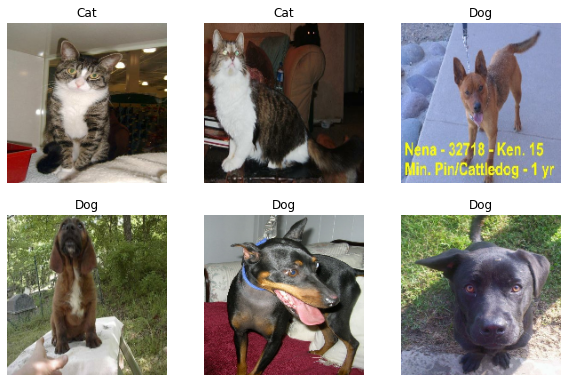

In [58]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
len(dataset)

17

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
len(train_ds)

13

In [12]:
len(val_ds)

1

In [13]:
len(test_ds)

3

In [14]:
train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)

In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [19]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (6, 180, 180, 3)          0         
                                                                 
 conv2d (Conv2D)             (6, 178, 178, 32)         896       
                                                                 
 max_pooling2d (MaxPooling2  (6, 89, 89, 32)           0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (6, 87, 87, 64)           18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (6, 43, 43, 64)           0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (6, 118336)              

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [34]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
13/13 [==============================] - 7s 533ms/step - loss: 0.5657 - accuracy: 0.6667 - val_loss: 0.3441 - val_accuracy: 0.8333
Epoch 2/50
13/13 [==============================] - 7s 529ms/step - loss: 0.5252 - accuracy: 0.7308 - val_loss: 0.4137 - val_accuracy: 0.6667
Epoch 3/50
13/13 [==============================] - 8s 588ms/step - loss: 0.5828 - accuracy: 0.6795 - val_loss: 0.3012 - val_accuracy: 0.8333
Epoch 4/50
13/13 [==============================] - 7s 537ms/step - loss: 0.5070 - accuracy: 0.7692 - val_loss: 0.2363 - val_accuracy: 1.0000
Epoch 5/50
13/13 [==============================] - 7s 525ms/step - loss: 0.5140 - accuracy: 0.7436 - val_loss: 0.3106 - val_accuracy: 0.8333
Epoch 6/50
13/13 [==============================] - 7s 534ms/step - loss: 0.6073 - accuracy: 0.7564 - val_loss: 0.3160 - val_accuracy: 1.0000
Epoch 7/50
13/13 [==============================] - 7s 537ms/step - loss: 0.5695 - accuracy: 0.6923 - val_loss: 0.2989 - val_accuracy: 1.0000
Epoch 

In [35]:
scores = model.evaluate(test_ds)

3/3 [==============================] - 1s 196ms/step - loss: 0.1471 - accuracy: 0.8889


In [36]:
scores

[0.14714458584785461, 0.8888888955116272]

In [37]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 13}

In [38]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [39]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.5656709671020508,
 0.5252227187156677,
 0.582831859588623,
 0.5069694519042969,
 0.5140240788459778]

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

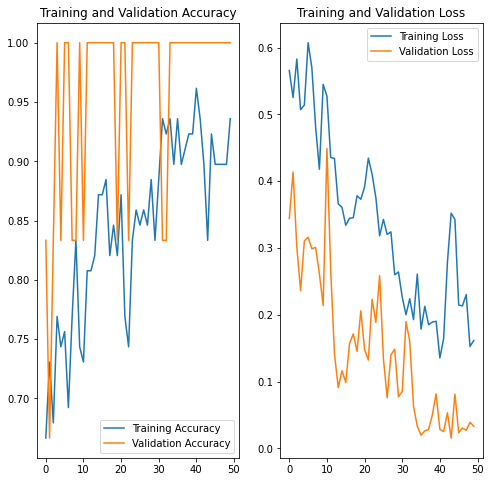

In [43]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Dog
1/1 [==============================] - 0s 254ms/step
predicted label: Dog


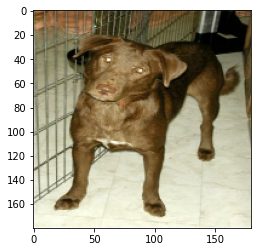

In [44]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [45]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 43ms/step


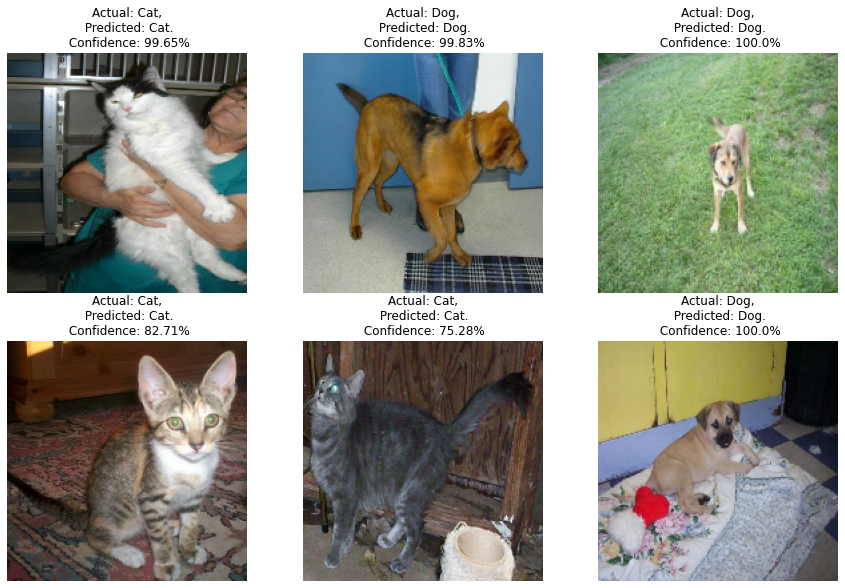

In [61]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [63]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [64]:
model.save("../dog-cat.h5")

C:\Users\BnBazz\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
